In [ ]:
# import packages we need for this project

import requests
import re
import json
import string
import unicodedata
import nltk

import pandas as pd 
import numpy as np
from bs4 import BeautifulSoup
from IPython.display import display

import gensim 
from gensim.parsing.preprocessing import remove_stopwords
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
 
nltk.download('stopwords')
import sklearn
from sklearn.metrics.pairwise import cosine_similarity;


pd.set_option('display.max_columns', 500)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
            BASE_URLS = {"machine learning": 
             ["https://www.simplilearn.com/tutorials/machine-learning-tutorial/machine-learning-interview-questions","tutorialContent"],
             "big data": 
             ["https://www.simplilearn.com/tutorials/hadoop-tutorial/hadoop-interview-questions","tutorialContent"],
             "python":
             ["https://www.simplilearn.com/tutorials/python-tutorial/python-interview-questions","tutorialContent"],
            "product manager": 
             ["https://www.simplilearn.com/project-management-interview-questions-and-answers-article","info-details"],
              "artificial intelligence": 
             ["https://www.simplilearn.com/artificial-intelligence-ai-interview-questions-and-answers-article","info-details"],
             "Big Data and Analytics": 
             ["https://www.simplilearn.com/tutorials/data-science-tutorial/data-science-interview-questions", "tutorialContent"],
             "Digital Marketing": 
             ["https://www.simplilearn.com/marketing-interview-questions-and-answers-article", "info-details"],
             "Career Fast-Track": 
             ["https://www.simplilearn.com/after-interview-questions-to-ask-an-employer-article", "info-details"],
             "Other Segments": 
             ["https://www.simplilearn.com/tutorials/java-tutorial/java-interview-questions", "tutorialContent"],
             "Virtualization and Cloud Computing": 
             ["https://www.simplilearn.com/tutorials/aws-tutorial/aws-interview-questions","tutorialContent"],
            }
             
all_questions = []
for tech, url in BASE_URLS.items():
    html = requests.get(url[0]).text
    soup = BeautifulSoup(html, "html.parser")
    questionclass = soup.find("div", {"class": url[1]})
    questions = questionclass.findAll("h3")
    for q in questions:
        a = q.find_next('p').text
        all_questions.append([tech,q.text,a])

In [ ]:
cols = ['skills','questions','answers']
qdf = pd.DataFrame(all_questions,columns=cols)





In [ ]:
qdf.sample(n=5)

,skills,questions,answers
132,python,18. Differentiate Between append() and extend().,append()
76,big data,41. What are the different components of a Hiv...,The different components of the Hive are:
15,machine learning,16. Compare K-means and KNN Algorithms.,The classifier is called ânaiveâ because i...
26,machine learning,27. Define Precision and Recall.,Precision is the ratio of several events you c...
226,Big Data and Analytics,14. What are recommender systems?,A recommender system predicts what a user woul...


In [ ]:
qdf.tail(n=5)

,skills,questions,answers
424,Virtualization and Cloud Computing,16. This cross-platform video game development...,The aforementioned AWS interview questions and...
425,Virtualization and Cloud Computing,17. You are the Project Manager of your compan...,The aforementioned AWS interview questions and...
426,Virtualization and Cloud Computing,18. You are the chief Cloud Architect at your ...,The aforementioned AWS interview questions and...
427,Virtualization and Cloud Computing,19. As a database administrator. you will empl...,The aforementioned AWS interview questions and...
428,Virtualization and Cloud Computing,20. A part of your marketing work requires you...,The aforementioned AWS interview questions and...


# Preprocessing 

Most NLP tasks involve preprocessing. For this task we are performing the following preprocessing : 
1. Removing all characters that are not alpha numeric
2. Removing stopwords - commonly used words such as 'a', 'to', 'in' and so on.. that do not contribute to the semantic similarity between two sentences.

We apply this to both the FAQ questions and the user query sentence.

Note that we have an option to not perform stopword removal. This is because some of the later models such as BERT work well without stopword removal - and we will try that out.

In [ ]:
#Cleaning and stripping HTML
def get_cleaned_sentences(text,w_stop):
    clean = re.compile('<.*?>')
    cleantext = re.sub(clean, '', text)
    cleantext = unicodedata.normalize('NFKD', cleantext).encode('ascii','ignore').decode("utf8")
    cleantext = re.sub(r'^\d+','',cleantext)
    table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    cleantext = cleantext.translate(table)
    cleantext = cleantext.lower().strip()

    stop_words = set(stopwords.words('english')) 
    if w_stop:
        cleantext = [w for w in cleantext.split() if w not in stop_words]
        cleantext = " ".join(cleantext)

    return cleantext

In [ ]:
qdf['questions'] = qdf['questions'].apply(get_cleaned_sentences,w_stop=False)
qdf['answers'] = qdf['answers'].apply(get_cleaned_sentences,w_stop=False)

qdf['clean_questions'] = qdf['questions'].apply(get_cleaned_sentences,w_stop=True)
qdf['clean_questions'] = qdf.apply(lambda x: x['clean_questions']+" "+ x['skills'], axis=1)

In [ ]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(qdf['clean_questions'])
# Create data frame
df_countvec = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
df_countvec.head()

,10,150,16,19,30,350,3x3,50,53,96,able,access,accessing,according,accounts,accuracy,achieved,across,actionable,activities,actual,actually,add,address,addresses,adjust,adjusting,administration,administrator,advancement,advantage,age,agent,agents,aggregate,ai,aisa,aix,algorithm,algorithms,allocate,allocates,allocation,allocations,allow,allows,along,alphanumeric,already,also,alternative,always,amazon,ami,among,amounts,anaivea,analysis,analytics,and,android,another,answer,aothera,apache,apis,app,append,apple,applet,application,applications,approach,appropriate,apps,architect,architects,architecture,areas,args,arguments,array,arraylist,arrays,artificial,asked,assigned,association,asupera,atemp,atest,athisa,atraining,attack,audio,authenticated,authentications,auto,automate,automatic,automatically,automating,availability,available,avoid,avoided,awareness,aws,back,backfired,backup,bad,balancers,balancing,banana,based,basic,basis,bayes,bayesian,beanstalk,become,behavior,benefits,best,beyond,bias,biases,big,biggest,binding,bivariate,blocks,blood,bloom,bought,boughta,brief,briefing,briefly,bring,bucket,build,building,built,business,businesses,buy,cache,calculate,called,cancer,cannot,capabilities,capacity,care,career,case,catalog,categorical,categories,cause,centralized,chain,challenges,challenging,change,changes,characters,charge,check,checking,chess,chief,choice,cholesterol,choose,class,classes,classification,classifier,classify,classloader,cloning,cloud,cloudformation,cloudfront,cloudtrail,cloudwatch,cluster,code,codegen,col,collaborative,collection,column,columns,combiner,command,commands,committed,common,communicate,communication,compaction,company,compare,comparison,completely,complex,components,compute,computer,computing,concept,conferencing,config,configuration,configure,conflicts,confounding,confusion,connect,connection,consider,considering,consistency,consisting,console,constraint,constructor,consultants,consuming,container,containerized,contents,continuous,contractual,contribute,control,converge,convert,copy,cores,correct,corrupted,cost,costs,could,count,...,rows,rpo,rto,rules,run,running,s3,sampling,satisfaction,scalable,scale,scaling,schedulers,schema,scope,script,scripts,second,secure,security,see,seen,segment,segments,select,selection,semi,send,sending,sensitive,sequence,series,server,servers,service,services,servlets,session,set,seta,sets,setup,several,shallow,shared,show,side,sign,significance,significant,similar,single,singleton,sites,situation,six,size,skill,sklearn,slower,small,smaller,snapshots,snowball,snowmobile,software,solaris,solution,solutions,solve,someone,sort,spam,specific,specifiers,speculative,spilling,split,splits,spreadsheet,spring,sql,sqoop,square,ssh,stack,stages,stakeholder,star,starting,state,statement,static,stationery,status,steps,stopping,store,stored,stores,strategy,string,study,studying,style,substring,successful,successfully,suits,summary,super,supervised,support,supports,suppose,survivorship,svm,system,systems,table,tables,tabs,tackle,tackled,take,taken,takes,target,targeted,targeting,task,tasks,team,techniques,tell,template,temporary,tensorflow,term,terminating,terms,test,testing,text,th,thereas,things,thousands,thread,three,time,times,today,together,tolerant,tool,tools,top,total,tough,towards,track,trade,traffic,train,training,transfer,treated,tree,trees,true,trying,tuple,two,txta,type,types,uncertainties,uncertainty,understand,unhappy,univariate,unpickling,unsupervised,update,updated,upgrade,uploaded,us,usage,use,used,user,users,usersa,uses,using,v1,validation,valuable,value,values,variable,variables,variance,variants,various,vast,vectors,vendor,versus,video,virtualization,visitors,visualize,void,vpc,waf,want,way,ways,web,website,well,whether,whitespace,whole,width,window,windows,wish,without,word,words,work,worked,working,works,world,would,wrapper,write,written,xbox,xrange,yarn,yes,youave,zero,zone
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

Analyzing text statistics

In [90]:
import seaborn as sns
from nltk.corpus import stopwords
from collections import  Counter
import matplotlib.pyplot as plt


def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y,y=x)

In [95]:
qdf.head()

,skills,questions,answers,clean_questions
0,machine learning,what are the different types of machine learning,there are three types of machine learning,different types machine learning machine learning
1,machine learning,what is overfitting and how can you avoid it a,overfitting is a situation that occurs when a ...,overfitting avoid machine learning
2,machine learning,what is atraining seta and atest seta in a mac...,there is a three step process followed to crea...,atraining seta atest seta machine learning mod...
3,machine learning,how do you handle missing or corrupted data in...,one of the easiest ways to handle missing or c...,handle missing corrupted data dataset machine ...
4,machine learning,how can you choose a classifier based on a tra...,when the training set is small a model that h...,choose classifier based training set data size...


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


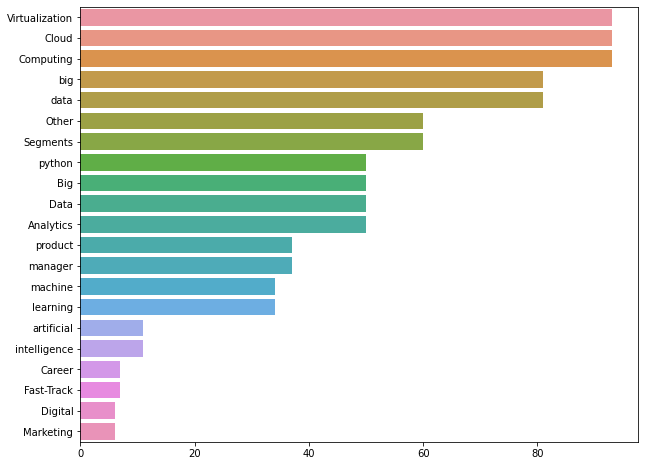

In [100]:
# Top skills Barchart
import nltk
plt.figure(figsize=[10,8])
nltk.download('stopwords')
plot_top_non_stopwords_barchart(qdf['skills'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


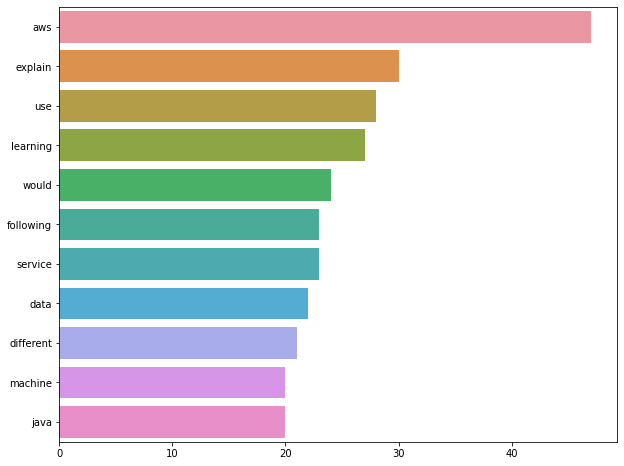

In [97]:
# Top questions Barchart
import nltk
plt.figure(figsize=[10,8])
nltk.download('stopwords')
plot_top_non_stopwords_barchart(qdf['questions'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


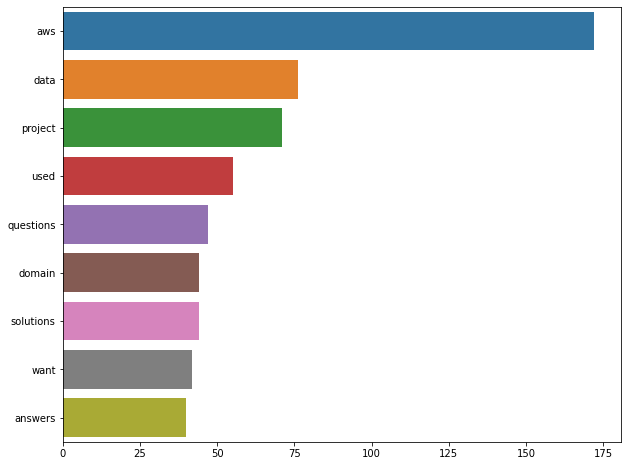

In [98]:
# Top answers Barchart
import nltk
plt.figure(figsize=[10,8])
nltk.download('stopwords')
plot_top_non_stopwords_barchart(qdf['answers'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


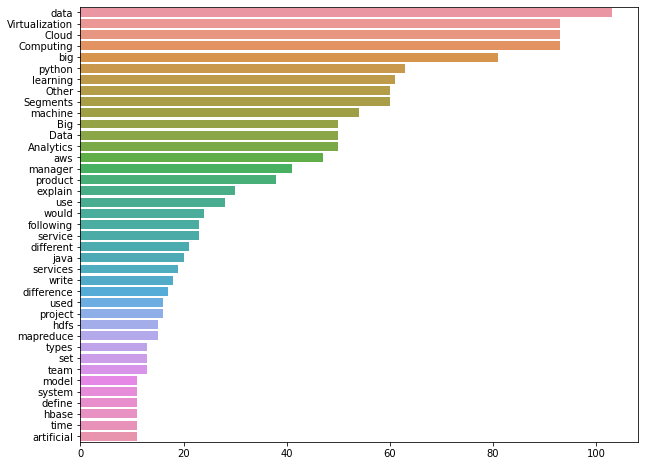

In [93]:
# Top Non-Stopwords Barchart
import nltk
plt.figure(figsize=[10,8])
nltk.download('stopwords')
plot_top_non_stopwords_barchart(qdf['clean_questions'])

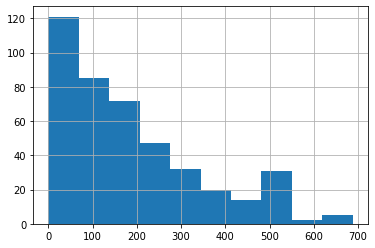

In [101]:
# Charachter frequency analysis
qdf['answers'].str.len().hist()

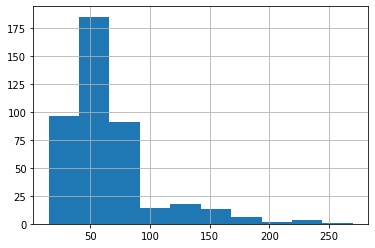

In [103]:
# Charachter frequency analysis
qdf['clean_questions'].str.len().hist()

In [104]:
# Code Snippet for Top N-grams Barchart

import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from collections import  Counter

def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

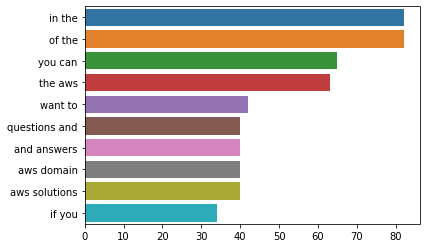

In [105]:
plot_top_ngrams_barchart(qdf['answers'],2)

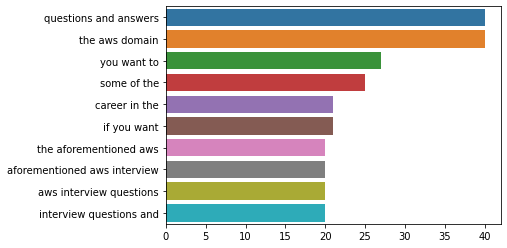

In [107]:
plot_top_ngrams_barchart(qdf['answers'],3)

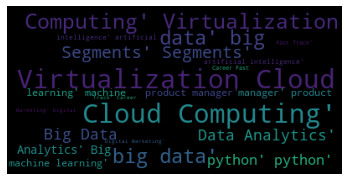

In [109]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
text = qdf['skills'].values 

wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### <span style="color:black">TF-IDF - Create Feature Matrix</span>

In [ ]:
text_data = qdf['clean_questions']
# Create the tf-idf feature matrix
tfidf = TfidfVectorizer()
feature_matrix = tfidf.fit_transform(text_data)

#### <span style="color:black">View Feature Matrix As Data Frame</span>

In [ ]:
# Create data frame
df_tdidf = pd.DataFrame(feature_matrix.toarray()[:1000], columns=tfidf.get_feature_names())
df_tdidf.head()

,10,150,16,19,30,350,3x3,50,53,96,able,access,accessing,according,accounts,accuracy,achieved,across,actionable,activities,actual,actually,add,address,addresses,adjust,adjusting,administration,administrator,advancement,advantage,age,agent,agents,aggregate,ai,aisa,aix,algorithm,algorithms,allocate,allocates,allocation,allocations,allow,allows,along,alphanumeric,already,also,alternative,always,amazon,ami,among,amounts,anaivea,analysis,analytics,and,android,another,answer,aothera,apache,apis,app,append,apple,applet,application,applications,approach,appropriate,apps,architect,architects,architecture,areas,args,arguments,array,arraylist,arrays,artificial,asked,assigned,association,asupera,atemp,atest,athisa,atraining,attack,audio,authenticated,authentications,auto,automate,automatic,automatically,automating,availability,available,avoid,avoided,awareness,aws,back,backfired,backup,bad,balancers,balancing,banana,based,basic,basis,bayes,bayesian,beanstalk,become,behavior,benefits,best,beyond,bias,biases,big,biggest,binding,bivariate,blocks,blood,bloom,bought,boughta,brief,briefing,briefly,bring,bucket,build,building,built,business,businesses,buy,cache,calculate,called,cancer,cannot,capabilities,capacity,care,career,case,catalog,categorical,categories,cause,centralized,chain,challenges,challenging,change,changes,characters,charge,check,checking,chess,chief,choice,cholesterol,choose,class,classes,classification,classifier,classify,classloader,cloning,cloud,cloudformation,cloudfront,cloudtrail,cloudwatch,cluster,code,codegen,col,collaborative,collection,column,columns,combiner,command,commands,committed,common,communicate,communication,compaction,company,compare,comparison,completely,complex,components,compute,computer,computing,concept,conferencing,config,configuration,configure,conflicts,confounding,confusion,connect,connection,consider,considering,consistency,consisting,console,constraint,constructor,consultants,consuming,container,containerized,contents,continuous,contractual,contribute,control,converge,convert,copy,cores,correct,corrupted,cost,costs,could,count,...,rows,rpo,rto,rules,run,running,s3,sampling,satisfaction,scalable,scale,scaling,schedulers,schema,scope,script,scripts,second,secure,security,see,seen,segment,segments,select,selection,semi,send,sending,sensitive,sequence,series,server,servers,service,services,servlets,session,set,seta,sets,setup,several,shallow,shared,show,side,sign,significance,significant,similar,single,singleton,sites,situation,six,size,skill,sklearn,slower,small,smaller,snapshots,snowball,snowmobile,software,solaris,solution,solutions,solve,someone,sort,spam,specific,specifiers,speculative,spilling,split,splits,spreadsheet,spring,sql,sqoop,square,ssh,stack,stages,stakeholder,star,starting,state,statement,static,stationery,status,steps,stopping,store,stored,stores,strategy,string,study,studying,style,substring,successful,successfully,suits,summary,super,supervised,support,supports,suppose,survivorship,svm,system,systems,table,tables,tabs,tackle,tackled,take,taken,takes,target,targeted,targeting,task,tasks,team,techniques,tell,template,temporary,tensorflow,term,terminating,terms,test,testing,text,th,thereas,things,thousands,thread,three,time,times,today,together,tolerant,tool,tools,top,total,tough,towards,track,trade,traffic,train,training,transfer,treated,tree,trees,true,trying,tuple,two,txta,type,types,uncertainties,uncertainty,understand,unhappy,univariate,unpickling,unsupervised,update,updated,upgrade,uploaded,us,usage,use,used,user,users,usersa,uses,using,v1,validation,valuable,value,values,variable,variables,variance,variants,various,vast,vectors,vendor,versus,video,virtualization,visitors,visualize,void,vpc,waf,want,way,ways,web,website,well,whether,whitespace,whole,width,window,windows,wish,without,word,words,work,worked,working,works,world,would,wrapper,write,written,xbox,xrange,yarn,yes,youave,zero,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [ ]:
query = "python"
query_vec = vectorizer.transform([query])

# Compute cosine similarity matrix
results  = cosine_similarity(df_tdidf, query_vec)


# Initializing N  
N = 5

# Get Top N elements from Records 
# Using sorted() + lambda 
res = sorted(results, key = lambda x: x[0], reverse = True)[:N]

In [ ]:
sentences=qdf.clean_questions 
#sentences=cleaned_sentences

# Split it by white space 
sentence_words = [[word for word in document.split() ]
         for document in sentences]

from gensim import corpora

dictionary = corpora.Dictionary(sentence_words)
for key, value in dictionary.items():
    print(key, ' : ', value)

import pprint
bow_corpus = [dictionary.doc2bow(text) for text in sentence_words]
for sent,embedding in zip(sentences,bow_corpus):
    print(sent)
    print(embedding)

# tags
tags="product manager"
question_embedding = dictionary.doc2bow(tags.split())


print("\n\n",tags,"\n",question_embedding)

0  :  different
1  :  learning
2  :  machine
3  :  types
4  :  avoid
5  :  overfitting
6  :  allocate
7  :  atest
8  :  atraining
9  :  data
10  :  model
11  :  much
12  :  seta
13  :  sets
14  :  test
15  :  training
16  :  validation
17  :  corrupted
18  :  dataset
19  :  handle
20  :  missing
21  :  based
22  :  choose
23  :  classifier
24  :  set
25  :  size
26  :  algorithms
27  :  confusion
28  :  explain
29  :  matrix
30  :  respect
31  :  false
32  :  negative
33  :  positive
34  :  significant
35  :  building
36  :  stages
37  :  three
38  :  deep
39  :  differences
40  :  applications
41  :  businesses
42  :  modern
43  :  supervised
44  :  semi
45  :  techniques
46  :  unsupervised
47  :  difference
48  :  deductive
49  :  inductive
50  :  compare
51  :  k
52  :  knn
53  :  means
54  :  anaivea
55  :  bayes
56  :  naive
57  :  chess
58  :  game
59  :  play
60  :  reinforcement
61  :  system
62  :  using
63  :  algorithm
64  :  classification
65  :  know
66  :  problem
67  : 

In [ ]:
def retrieveAndPrintFAQAnswer(question_embedding,sentence_embeddings,FAQdf,sentences):
    max_sim=-1;
    index_sim=-1;
    questions = []
    for index,faq_embedding in enumerate(sentence_embeddings):
        sim=cosine_similarity(faq_embedding,question_embedding)[0][0];
        #print(index, sim, sentences[index])
        if sim>max_sim:
            max_sim=sim;
            index_sim=index;
        questions.append([sim, FAQdf.iloc[index,1],FAQdf.iloc[index,2]])
    return questions


    

In [ ]:
print("You can enter query in single line such as: The incumbent should be an expert in artifical intelligence or enter a keyword like django")
query4mUser = input("Enter your value: ")
print(query4mUser)
#tags = "The incumbent should be an expert in artifical intelligence"
question_embedding = dictionary.doc2bow(query4mUser.split())
questions = retrieveAndPrintFAQAnswer(question_embedding,bow_corpus,qdf,sentences);


# Initializing N  
N = 5

# Get Top N elements from Records 
# Using sorted() + lambda 
res = sorted(questions, key = lambda x: x[0], reverse = True)[:N]
  
# printing questions 
for q,i in zip(res,range(1,N+1)):
    print("\n=================================================================")
    #print("similarity:",q[0])
    print("Q"+str(i)+": ",q[1])
    print("\n")
    print("Ans"+str(i)+": ",q[2])

You can enter query in single line such as: The incumbent should be an expert in artifical intelligence or enter a keyword like django
Enter your value: aws
aws

Q1:  what is a classloader


Ans1:  a classloader in java is a subsystem of java virtual machine  dedicated to loading class files when a program is executed  classloader is the first to load the executable file

Q2:  what is a marker interface


Ans2:  an empty interface in javajava is referred to as a marker interface  serializable and cloneable are some famous examples of marker interface a

Q3:  what is an exception


Ans3:  an exception in java is considered an unexpected event that can disrupt the program s normal flow  these events can be fixed through the process of exception handling

Q4:  what is the final keyword in java


Ans4:  the term final is a predefined word in java that is used while declaring values to variables  when a value is declared using the final keyword  then the variable s value remains constant th